In [1]:
# ==========================================
# PART 1: DATA LOADING AND EXPLORATION
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [2]:
# Load the dataset 
data = pd.read_csv(r'C:\Users\jhack\ALY6020\Week One Project\adult-all.csv')
df = data

In [3]:
# Check the first few lines 
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
# Rename columns 
data.columns = ['age', 'workclass', 'inlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

,age,workclass,inlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
# Review dataset structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48841 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48841 non-null  int64 
 1   workclass       48841 non-null  object
 2   inlwgt          48841 non-null  int64 
 3   education       48841 non-null  object
 4   education-num   48841 non-null  int64 
 5   marital-status  48841 non-null  object
 6   occupation      48841 non-null  object
 7   relationship    48841 non-null  object
 8   race            48841 non-null  object
 9   sex             48841 non-null  object
 10  capital-gain    48841 non-null  int64 
 11  capital-loss    48841 non-null  int64 
 12  hours-per-week  48841 non-null  int64 
 13  native-country  48841 non-null  object
 14  income          48841 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [6]:
# Remove unncessary inlwgt variable 
data.drop(columns = ['inlwgt', 'education'], inplace = True)

In [7]:
# Look for missing values 
print("\n=== MISSING VALUES CHECK ===")
missing_counts = df.isin([' ?', '?']).sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])


=== MISSING VALUES CHECK ===
                Missing_Count  Missing_Percent
occupation               2809         5.751315
workclass                2799         5.730841
native-country            857         1.754673


In [8]:
# ==========================================
# PART 2: DATA CLEANING
# ==========================================

# Replace '?' with NaN for proper handling
df = df.replace([' ?', '?'], np.nan)

print("1. Missing Value Treatment:")
print(f"   - Workclass missing: {df['workclass'].isna().sum()} ({df['workclass'].isna().mean()*100:.1f}%)")
print(f"   - Occupation missing: {df['occupation'].isna().sum()} ({df['occupation'].isna().mean()*100:.1f}%)")
print(f"   - Native-country missing: {df['native-country'].isna().sum()} ({df['native-country'].isna().mean()*100:.1f}%)")

1. Missing Value Treatment:
   - Workclass missing: 2799 (5.7%)
   - Occupation missing: 2809 (5.8%)
   - Native-country missing: 857 (1.8%)


In [9]:
# Strategy: Drop rows with missing values since they represent <6% of data
print("   Decision: Remove rows with missing values (preserves data integrity)")
df_clean = df.dropna()
print(f"   Rows after cleaning: {len(df_clean)} (removed {len(df) - len(df_clean)} rows)")

   Decision: Remove rows with missing values (preserves data integrity)
   Rows after cleaning: 45221 (removed 3620 rows)


In [10]:
# Clean string values 
string_columns = df_clean.select_dtypes(include=['object']).columns
for col in string_columns:
    df_clean[col] = df_clean[col].str.strip()
    print(f"   - Cleaned {col}: {df_clean[col].nunique()} unique values")

print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

   - Cleaned workclass: 7 unique values
   - Cleaned marital-status: 7 unique values
   - Cleaned occupation: 14 unique values
   - Cleaned relationship: 6 unique values
   - Cleaned race: 5 unique values
   - Cleaned sex: 2 unique values
   - Cleaned native-country: 41 unique values
   - Cleaned income: 2 unique values

Final cleaned dataset shape: (45221, 13)


C:\Users\jhack\AppData\Local\Temp\ipykernel_22964\3194614932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = df_clean[col].str.strip()


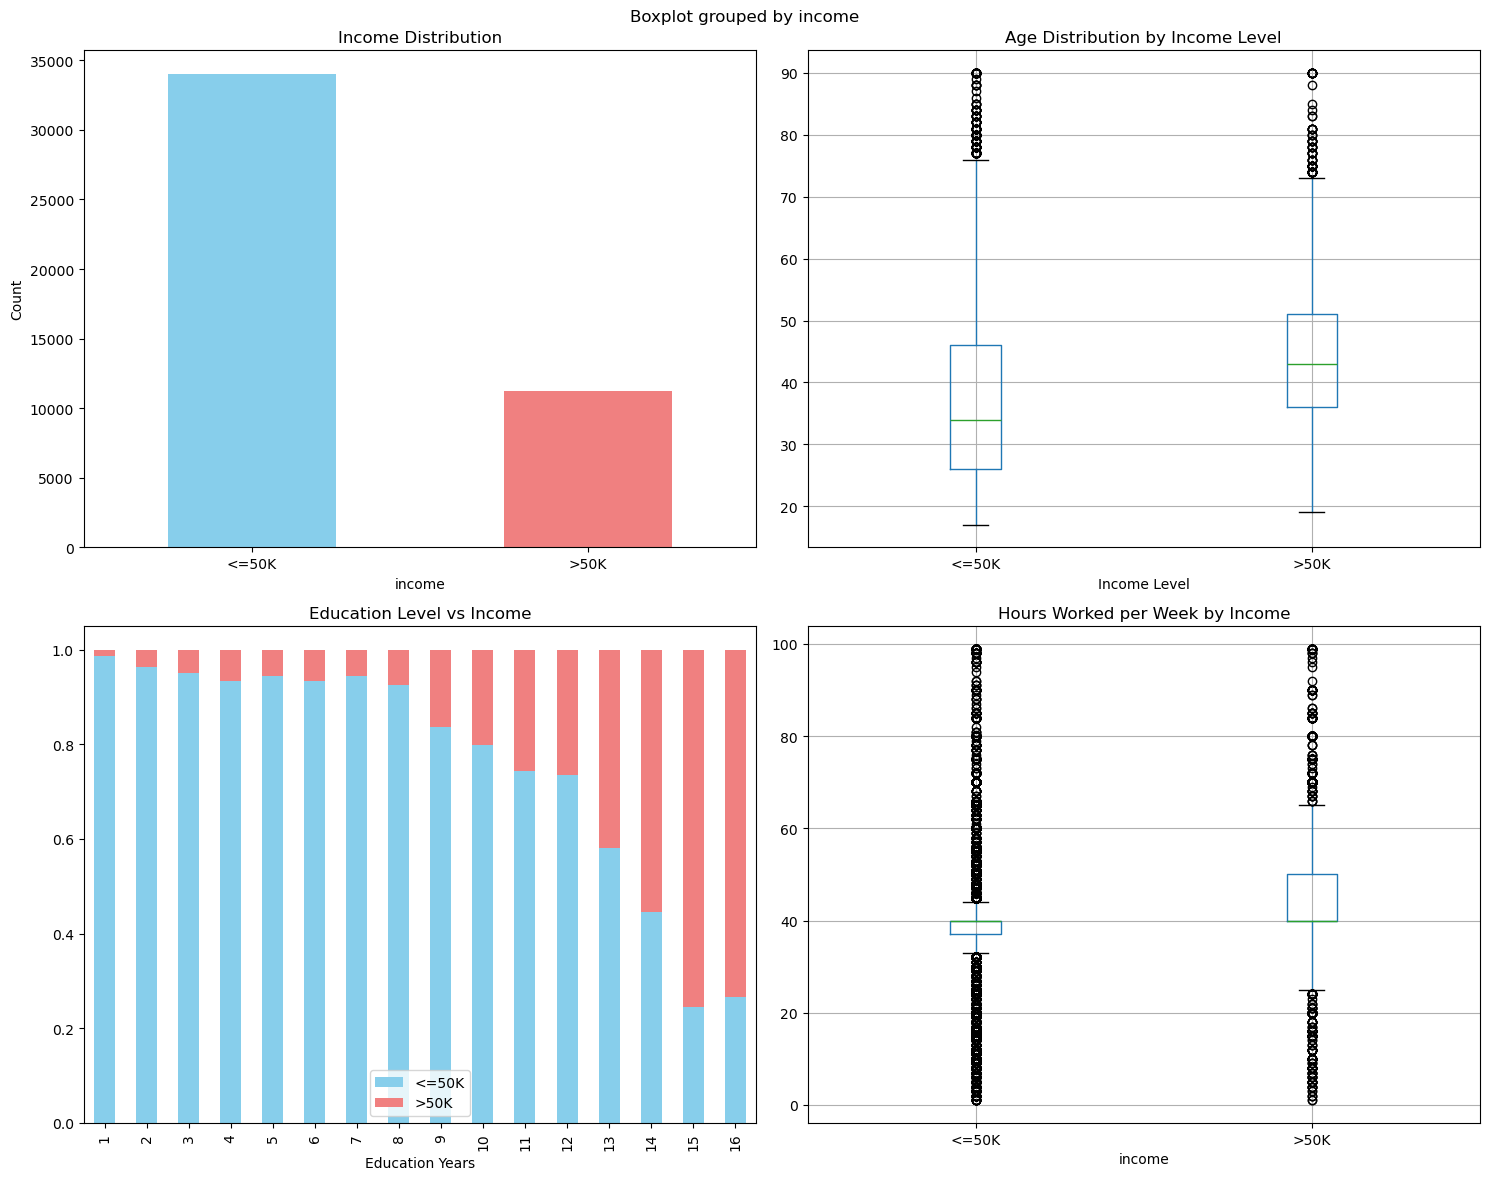

In [11]:
# ==========================================
# PART 3: EXPLORATORY DATA ANALYSIS
# ==========================================

# Visualize target distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Income distribution
df_clean['income'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Income Distribution')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Age distribution by income
df_clean.boxplot(column='age', by='income', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Income Level')
axes[0,1].set_xlabel('Income Level')

# Education level by income
education_income = pd.crosstab(df_clean['education-num'], df_clean['income'], normalize='index')
education_income.plot(kind='bar', stacked=True, ax=axes[1,0], color=['skyblue', 'lightcoral'])
axes[1,0].set_title('Education Level vs Income')
axes[1,0].set_xlabel('Education Years')
axes[1,0].legend(['<=50K', '>50K'])

# Hours per week distribution
df_clean.boxplot(column='hours-per-week', by='income', ax=axes[1,1])
axes[1,1].set_title('Hours Worked per Week by Income')

plt.tight_layout()
plt.show()

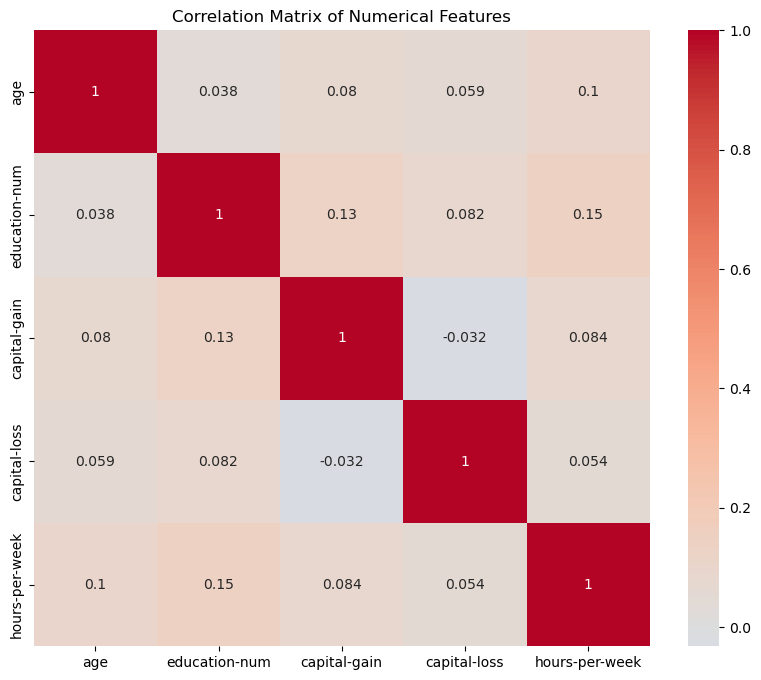

In [12]:
# Correlation analysis for numerical features
numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
corr_matrix = df_clean[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [58]:
# ==========================================
# PART 4: Data Engineeering
# ==========================================
# Create new features that might be predictive
df_clean['age_group'] = pd.cut(df_clean['age'], 
                               bins=[0, 25, 35, 45, 55, 100], 
                               labels=['Young', 'Young_Adult', 'Middle_Age', 'Senior', 'Elderly'])
df_clean['has_capital_gain'] = (df_clean['capital-gain'] > 0).astype(int)
df_clean['has_capital_loss'] = (df_clean['capital-loss'] > 0).astype(int)
df_clean['net_capital'] = df_clean['capital-gain'] - df_clean['capital-loss']

df_clean['work_intensity'] = pd.cut(df_clean['hours-per-week'], 
                                    bins=[0, 20, 40, 60, 100], 
                                    labels=['Part_time', 'Full_time', 'Overtime', 'Workaholic'])
education_mapping = {
    1: 'Elementary', 2: 'Elementary', 3: 'Elementary', 4: 'Elementary',
    5: 'Middle', 6: 'Middle', 7: 'Middle', 8: 'Middle',
    9: 'High_School', 10: 'High_School', 11: 'High_School', 12: 'High_School',
    13: 'College', 14: 'College', 15: 'Graduate', 16: 'Graduate'
}
df_clean['education_level'] = df_clean['education-num'].map(education_mapping)

print(f"Added features: age_group, has_capital_gain, has_capital_loss, net_capital, work_intensity, education_level")
print(f"Final dataset shape: {df_clean.shape}")

Added features: age_group, has_capital_gain, has_capital_loss, net_capital, work_intensity, education_level
Final dataset shape: (45221, 19)


C:\Users\jhack\AppData\Local\Temp\ipykernel_22964\3751709163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age_group'] = pd.cut(df_clean['age'],
C:\Users\jhack\AppData\Local\Temp\ipykernel_22964\3751709163.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['has_capital_gain'] = (df_clean['capital-gain'] > 0).astype(int)
C:\Users\jhack\AppData\Local\Temp\ipykernel_22964\3751709163.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [59]:
# ==========================================
# PART 5: KNN Prep
# ==========================================
# Separate features and target
X = df_clean.drop('income', axis=1)
y = df_clean['income']

In [60]:
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

Target encoding: {'<=50K': 0, '>50K': 1}


In [61]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")


Categorical features (8): ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'education_level']
Numerical features (6): ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'net_capital']


In [62]:
# Create preprocessing pipelines
# For categorical features: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])


In [63]:
# For numerical features: Impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [64]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [65]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Train set shape: (36176, 18)
Test set shape: (9045, 18)
Train class distribution: [27210  8966]
Test class distribution: [6803 2242]


In [76]:
# ==========================================
# PART 6: K Value Optimization
# ==========================================
# Check class distribution
print("CLASS DISTRIBUTION CHECK:")
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"Class distribution: {class_distribution}")
print(f"Class 0 percentage: {counts[0]/len(y_train)*100:.1f}%")
print(f"Class 1 percentage: {counts[1]/len(y_train)*100:.1f}%")

CLASS DISTRIBUTION CHECK:
Class distribution: {0: 27210, 1: 8966}
Class 0 percentage: 75.2%
Class 1 percentage: 24.8%


In [77]:
# Create stratified cross-validation to ensure balanced folds
print(f"\nUsing StratifiedKFold to ensure each fold has both classes...")
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Using StratifiedKFold to ensure each fold has both classes...


In [78]:
# Initialize results
cv_scores = []
k_range = range(1, 31, 2)

In [79]:
# Create the pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

print("Testing K values with 5-fold stratified cross-validation...")
print("=" * 60)

for k in k_range:
    try:
        # Set K parameter
        knn_pipeline.set_params(classifier__n_neighbors=k)
        
        # Use stratified cross-validation
        scores = cross_val_score(
            knn_pipeline, 
            X_train, 
            y_train, 
            cv=stratified_cv,  
            scoring='accuracy',
            n_jobs=-1 
        )
        
        # Check if any scores are NaN
        if np.isnan(scores).any():
            print(f"K={k:2d}: WARNING - Some folds failed. Scores: {scores}")
            cv_scores.append(np.nanmean(scores))  # Use nanmean to handle NaN
        else:
            cv_scores.append(scores.mean())
            print(f"K={k:2d}: CV Accuracy = {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
            
    except Exception as e:
        print(f"K={k:2d}: FAILED - {str(e)[:100]}...")
        cv_scores.append(np.nan)
        continue

print("=" * 60)

Testing K values with 5-fold stratified cross-validation...
K= 1: WARNING - Some folds failed. Scores: [       nan 0.80511403 0.8056669  0.80953697 0.80110574]
K= 3: WARNING - Some folds failed. Scores: [       nan 0.83026952 0.82432619 0.82474084 0.82418798]
K= 5: WARNING - Some folds failed. Scores: [       nan 0.83911541 0.83441603 0.83911541 0.83524534]
K= 7: WARNING - Some folds failed. Scores: [       nan 0.84367657 0.84257084 0.84464409 0.83386317]
K= 9: WARNING - Some folds failed. Scores: [       nan 0.84353836 0.84561161 0.84685556 0.83455425]
K=11: WARNING - Some folds failed. Scores: [       nan 0.84478231 0.84657913 0.84450587 0.83953006]
K=13: WARNING - Some folds failed. Scores: [       nan 0.84768487 0.84809952 0.84602626 0.84118867]
K=15: WARNING - Some folds failed. Scores: [       nan 0.85031099 0.84906704 0.84823773 0.84353836]
K=17: WARNING - Some folds failed. Scores: [       nan 0.85141672 0.84975812 0.84727021 0.84533518]
K=19: WARNING - Some folds failed. Score

In [80]:
# Find optimal K
valid_scores = [(i, k, score) for i, (k, score) in enumerate(zip(k_range, cv_scores)) 
                if not np.isnan(score)]

if valid_scores:
    # Find best score
    best_idx, optimal_k, best_score = max(valid_scores, key=lambda x: x[2])
    
    print(f"\n=== OPTIMIZATION RESULTS ===")
    print(f"Optimal K: {optimal_k}")
    print(f"Best CV Accuracy: {best_score:.4f}")
    print(f"Successfully tested {len(valid_scores)} out of {len(k_range)} K values")
    
    # Show top 5 K values
    print(f"\nTop 5 K values:")
    top_5 = sorted(valid_scores, key=lambda x: x[2], reverse=True)[:5]
    for rank, (_, k_val, score) in enumerate(top_5, 1):
        print(f"  {rank}. K={k_val}: {score:.4f}")
        


=== OPTIMIZATION RESULTS ===
Optimal K: 29
Best CV Accuracy: 0.8503
Successfully tested 15 out of 15 K values

Top 5 K values:
  1. K=29: 0.8503
  2. K=27: 0.8500
  3. K=23: 0.8499
  4. K=25: 0.8494
  5. K=21: 0.8494


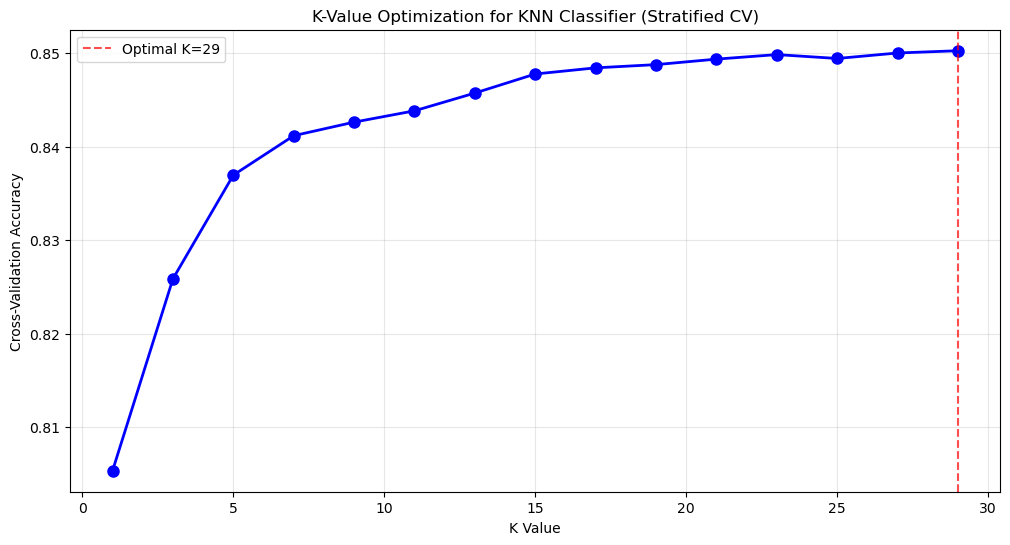

In [81]:
# Extract valid K values and scores for plotting
valid_k_values = [k for _, k, _ in valid_scores]
valid_accuracy_scores = [score for _, _, score in valid_scores]
        
plt.figure(figsize=(12, 6))
plt.plot(valid_k_values, valid_accuracy_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Optimal K={optimal_k}')
plt.xlabel('K Value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('K-Value Optimization for KNN Classifier (Stratified CV)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [82]:
# Reasoning for K selection
print(f"\n=== K-VALUE SELECTION REASONING ===")
print(f"Selected K = {optimal_k} because:")
print(f"1. Highest cross-validation accuracy: {best_score:.4f}")
print(f"2. Odd number prevents tie-breaking issues")
print(f"3. Not too small (avoids overfitting) nor too large (avoids underfitting)")
print(f"4. Approximately sqrt(n_samples) = {int(np.sqrt(len(X_train)))}")


=== K-VALUE SELECTION REASONING ===
Selected K = 29 because:
1. Highest cross-validation accuracy: 0.8503
2. Odd number prevents tie-breaking issues
3. Not too small (avoids overfitting) nor too large (avoids underfitting)
4. Approximately sqrt(n_samples) = 190


In [ ]:
# ==========================================
# PART 7: FINAL MODEL TRAINING
# ==========================================

In [83]:
final_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform'))
])

# Fit the model
final_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week',
                                                   'net_capital']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country',
                                                   'education_level'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=29))])

In [84]:
# Make predictions
y_pred_train = final_knn.predict(X_train)
y_pred_test = final_knn.predict(X_test)

In [85]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Overfitting Check: {train_accuracy - test_accuracy:.4f} (should be < 0.05)")


Training Accuracy: 0.8595
Test Accuracy: 0.8456
Overfitting Check: 0.0139 (should be < 0.05)


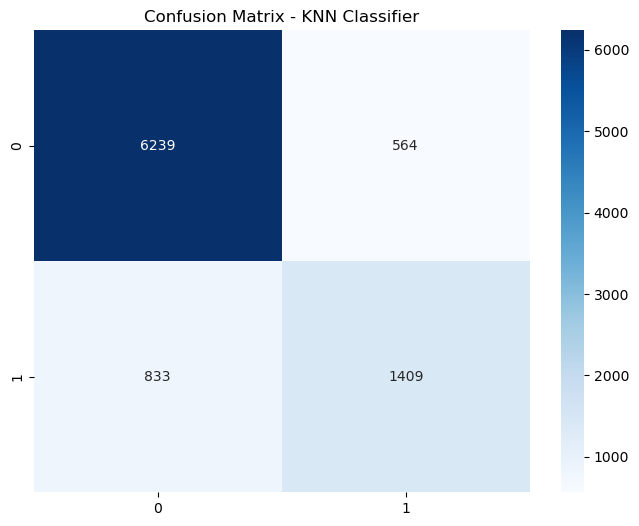

In [88]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN Classifier')
plt.show()

In [89]:
# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for >50K
specificity = tn / (tn + fp)  # Recall for <=50K
precision_high = tp / (tp + fp)  # Precision for >50K

print(f"\n=== ADDITIONAL METRICS ===")
print(f"Sensitivity (>50K detection): {sensitivity:.4f}")
print(f"Specificity (<=50K detection): {specificity:.4f}")
print(f"Precision for >50K: {precision_high:.4f}")


=== ADDITIONAL METRICS ===
Sensitivity (>50K detection): 0.6285
Specificity (<=50K detection): 0.9171
Precision for >50K: 0.7141


In [91]:
# ==========================================
# PART 8: FEATURE IMPORTANCE ANALYSIS
# ==========================================
perm_importance = permutation_importance(
    final_knn, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)

# Get feature names after preprocessing
feature_names = (numerical_features + 
                list(final_knn.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features)))

In [95]:
feature_names_matched = feature_names[:len(perm_importance.importances_mean)]
importance_df = pd.DataFrame({
    'feature': feature_names_matched,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

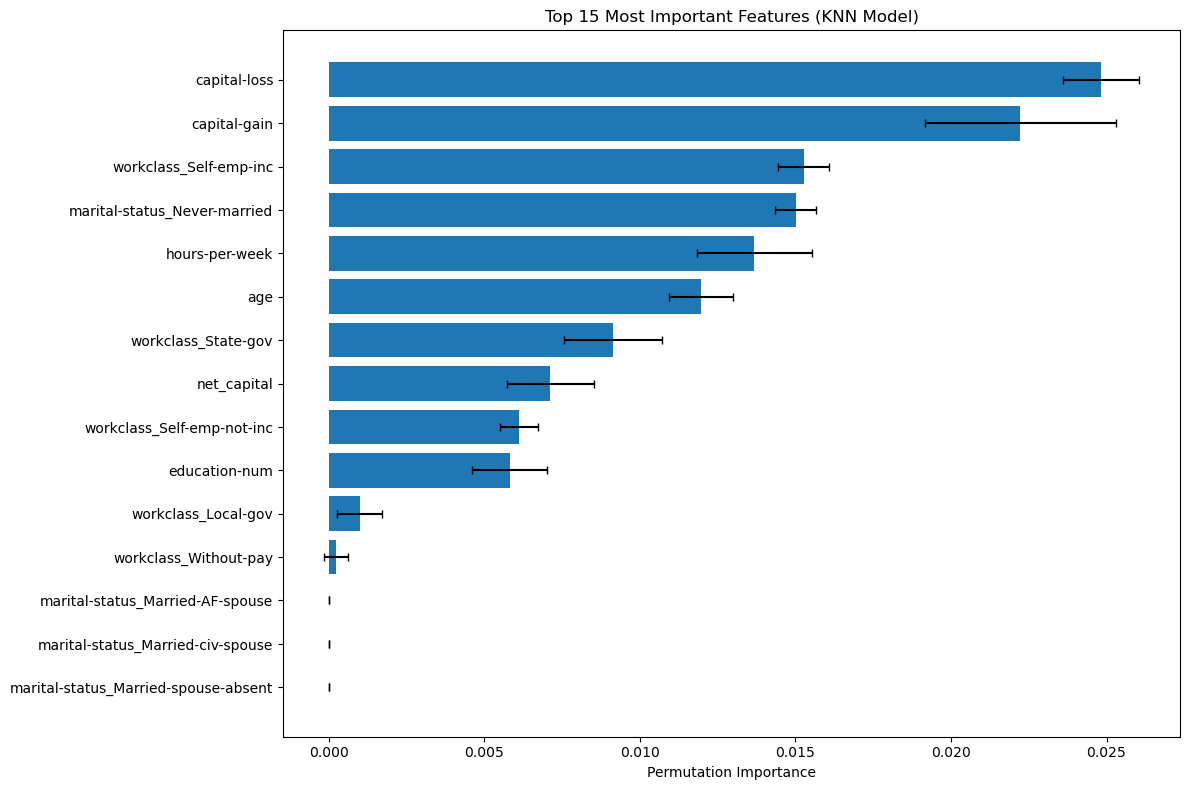

In [96]:
# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], 
         xerr=top_features['std'], capsize=3)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 15 Most Important Features (KNN Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [97]:
print("Top 10 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f} (+/- {row['std']:.4f})")

Top 10 Most Important Features:
 1. capital-loss              0.0248 (+/- 0.0012)
 2. capital-gain              0.0222 (+/- 0.0031)
 3. workclass_Self-emp-inc    0.0153 (+/- 0.0008)
 4. marital-status_Never-married 0.0150 (+/- 0.0007)
 5. hours-per-week            0.0137 (+/- 0.0018)
 6. age                       0.0120 (+/- 0.0010)
 7. workclass_State-gov       0.0092 (+/- 0.0016)
 8. net_capital               0.0071 (+/- 0.0014)
 9. workclass_Self-emp-not-inc 0.0061 (+/- 0.0006)
10. education-num             0.0058 (+/- 0.0012)


In [98]:
# ==========================================
# PART 9: BUSINESS INSIGHTS AND INTERPRETATION
# ==========================================
print("\n1. KEY FINDINGS:")
print("   • Overall model accuracy: {:.1f}%".format(test_accuracy * 100))
print("   • Successfully identifies high earners with {:.1f}% precision".format(precision_high * 100))
print("   • Model shows {:.1f}% sensitivity for detecting >$50K earners".format(sensitivity * 100))

print("\n2. MOST INFLUENTIAL FACTORS FOR INCOME CLASSIFICATION:")
top_5_features = importance_df.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_name = row['feature']
    importance = row['importance']
    
    # Provide business interpretation
    if 'capital_gain' in feature_name.lower():
        interpretation = "Investment income strongly predicts higher earnings"
    elif 'age' in feature_name.lower():
        interpretation = "Career experience (age) is crucial for income level"  
    elif 'education' in feature_name.lower():
        interpretation = "Educational attainment directly impacts earning potential"
    elif 'hours' in feature_name.lower():
        interpretation = "Work commitment affects income classification"
    elif 'marital' in feature_name.lower():
        interpretation = "Marital status correlates with income stability"
    else:
        interpretation = "Significant demographic/employment factor"
    
    print(f"   {i}. {feature_name}: {interpretation}")


1. KEY FINDINGS:
   • Overall model accuracy: 84.6%
   • Successfully identifies high earners with 71.4% precision
   • Model shows 62.8% sensitivity for detecting >$50K earners

2. MOST INFLUENTIAL FACTORS FOR INCOME CLASSIFICATION:
   1. capital-loss: Significant demographic/employment factor
   2. capital-gain: Significant demographic/employment factor
   3. workclass_Self-emp-inc: Significant demographic/employment factor
   4. marital-status_Never-married: Marital status correlates with income stability
   5. hours-per-week: Work commitment affects income classification


In [99]:
print("\n3. POLICY RECOMMENDATIONS:")
print("   • Education: Invest in higher education programs and vocational training")
print("   • Employment: Promote full-time employment opportunities")
print("   • Financial Literacy: Encourage investment and capital building programs")
print("   • Age Discrimination: Address potential age-related income disparities")
print("   • Work-Life Balance: Consider policies around work hours and income")

print("\n4. MODEL LIMITATIONS:")
print("   • Class imbalance: 76% of population earns ≤$50K")
print("   • Feature dependencies: Some attributes may be correlated")
print("   • Temporal: Data represents a snapshot, not dynamic changes")
print("   • Causation: Model shows correlation, not causation")


3. POLICY RECOMMENDATIONS:
   • Education: Invest in higher education programs and vocational training
   • Employment: Promote full-time employment opportunities
   • Financial Literacy: Encourage investment and capital building programs
   • Age Discrimination: Address potential age-related income disparities
   • Work-Life Balance: Consider policies around work hours and income

4. MODEL LIMITATIONS:
   • Class imbalance: 76% of population earns ≤$50K
   • Feature dependencies: Some attributes may be correlated
   • Temporal: Data represents a snapshot, not dynamic changes
   • Causation: Model shows correlation, not causation
